In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from dataclasses import dataclass, field

# Nested configuration structure
@dataclass(frozen=True)
class SignalConfig:
    """Signal parameters configuration"""
    fc: float
    fsymbol: float
    fs: float
    up_fs: float
    fs_num: int
    up_fs_num: int
    constellation_offset: float
    
    # Calculated properties
    symbol_duration: float = field(init=False)
    
    def __post_init__(self):
        object.__setattr__(self, 'symbol_duration', 1 / self.fsymbol)

@dataclass(frozen=True)
class CSVConfig:
    """CSV file paths configuration"""
    original: str
    t0: str
    pn_t0: str
    fs: str
    up_fs: str
    awgn_t0: str

@dataclass(frozen=True)
class AWGNConfig:
    """AWGN parameters configuration"""
    snr_db: float
    signal_power: float

    # Calculated properties
    snr_linear: float = field(init=False)
    noise_power: float = field(init=False)

    def __post_init__(self):
        object.__setattr__(self, 'snr_linear', 10 ** (self.snr_db / 10))
        object.__setattr__(self, 'noise_power', self.signal_power / self.snr_linear)

@dataclass(frozen=True)
class PhaseNoiseConfig:
    """Phase noise parameters configuration"""
    std_rad: float  # Standard deviation in radians
    
    # Calculated properties
    std_degree: float = field(init=False)
    std_time: float = field(init=False)
    
    def __post_init__(self):
        object.__setattr__(self, 'std_degree', self.std_rad * 180 / np.pi)

@dataclass(frozen=True)
class Config:
    """Main configuration class"""
    signal: SignalConfig
    csv: CSVConfig
    awgn: AWGNConfig
    pn: PhaseNoiseConfig

    def __post_init__(self):
        object.__setattr__(self.pn, 'std_time', self.pn.std_rad / (2 * np.pi * self.signal.fc))


# Create configuration instance
config = Config(
    signal=SignalConfig(
        fc=4e9,
        fsymbol=500e6,
        fs=32e9,
        up_fs=1024e9,
        fs_num=32,
        up_fs_num=1024,
        constellation_offset=0
    ),
    csv=CSVConfig(
        original='../csv/8PSK2PPM_500MBps.csv',
        t0='../csv/t0.csv',
        pn_t0='../csv/pn_t0.csv',
        fs='../csv/fs.csv',
        up_fs='../csv/up_fs.csv',
        awgn_t0='../csv/awgn_t0.csv'
    ),
        awgn=AWGNConfig(
        snr_db=20,
        signal_power=0.5
    ),
        pn=PhaseNoiseConfig(
        std_rad=40e-3
    )
)

## Pre-configure

In [66]:
# pre-configure the original file:
# 1. change the header to be time,data
# 2. make sure the time starts from 0
# 3. make the 99% of the data to be 0.99

# # Read CSV file
# df = pd.read_csv(config.csv.original)

# # Get column names and rename to time and data
# columns = df.columns.tolist()
# df.columns = ['time', 'data']

# # Ensure time starts from 0
# if len(df) > 0:
#     time_start = df['time'].iloc[0]
#     df['time'] = df['time'] - time_start

# # Scale, make the 99% of the data to be 0.99
# factor = 0.99 / df['data'].quantile(0.99)
# df['data'] = df['data'] * factor

# # Save processed file
# df.to_csv(config.csv.t0, index=False)

# df.describe()

df = pd.read_csv(config.csv.t0)

## Add phase noise

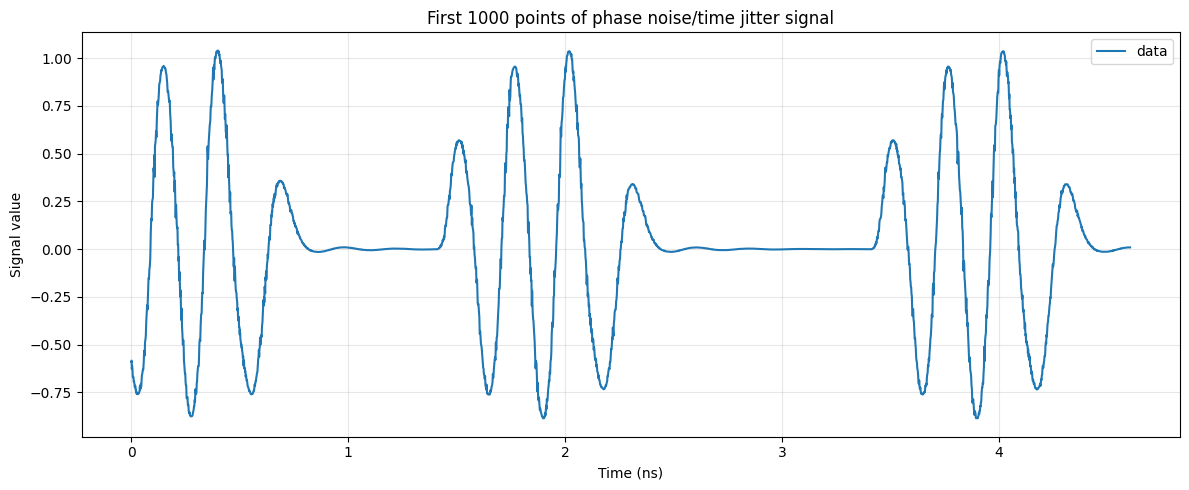

In [67]:
# data = pd.read_csv(config.csv.t0)
data = df

# generate phase noise
np.random.seed(42)
phase_noise = np.random.normal(0, config.pn.std_rad, len(data))

# Calculate time jitter noise
# Relationship between time jitter and phase noise: Δt = Δφ / (2π * f_carrier)
time_jitter = phase_noise / (2 * np.pi * config.signal.fc)

# Create output dataframe, keep only time and data columns
df_pn = pd.DataFrame()

# Add time column
df_pn['time'] = data['time']

# Apply time jitter noise to the original signal
# Get original time axis
t_original = np.array(data['time'].values)
t_jittered = t_original + time_jitter
data_original = np.array(data['data'].values)

# Use interpolation to get signal values at jittered time points
# from scipy.interpolate import interp1d

# Create interpolation function
# Use linear interpolation, extrapolate for boundaries
interp_func = sp.interpolate.interp1d(t_original, data_original,
                        kind='linear',
                        bounds_error=False,
                        fill_value=0)

# Sample at jittered time points
noisy_signal = interp_func(t_jittered)

df_pn['data'] = noisy_signal

# save to csv
# df_pn.to_csv(config.csv.pn_t0, index=False)

plot_data = df_pn.head(3000)

# Read and plot the first 1000 points
plt.figure(figsize=(12, 5))
plt.plot(plot_data['time'] * 1e9, plot_data['data'], label='data')
plt.xlabel('Time (ns)')
plt.ylabel('Signal value')
plt.title('First 1000 points of phase noise/time jitter signal')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## AWGN

Added AWGN noise: SNR=20 dB (linear=100.00), signal power=0.5, noise power=5.00e-03
           time      data
0  0.000000e+00 -0.560873
1  5.003320e-13 -0.570395
2  1.150268e-12 -0.680462
3  1.759056e-12 -0.601891
4  2.976630e-12 -0.388936


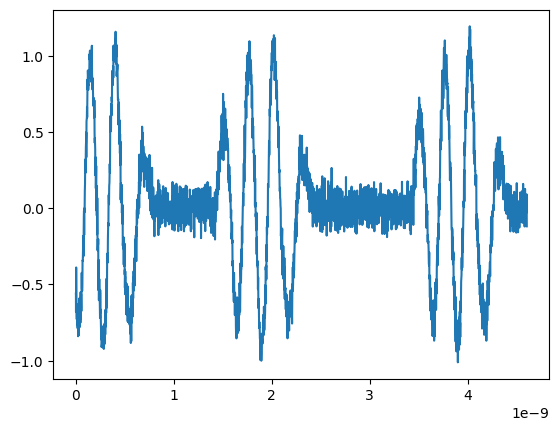

In [68]:
# df_awgn = pd.read_csv(config.csv.pn_t0)

# Generate AWGN noise
noise = np.random.normal(loc=0, scale=np.sqrt(config.awgn.noise_power), size=len(df_pn))

# Add noise to the signal
df_awgn = pd.DataFrame({'time': df_pn['time'], 'data': df_pn['data'] + noise})

print(f"Added AWGN noise: SNR={config.awgn.snr_db} dB (linear={config.awgn.snr_linear:.2f}), signal power={config.awgn.signal_power}, noise power={config.awgn.noise_power:.2e}")
print(df_awgn.head())

# df_awgn.to_csv(config.csv.awgn_t0, index=False)

plt.plot(df_awgn['time'][:3000], df_awgn['data'][:3000])
plt.show()

## Downsampling

Data resampled to 32 GHz.
           time      data
0  0.000000e+00 -0.560873
1  3.125000e-11 -0.723530
2  6.250000e-11 -0.537277
3  9.375000e-11  0.202738
4  1.250000e-10  0.828530


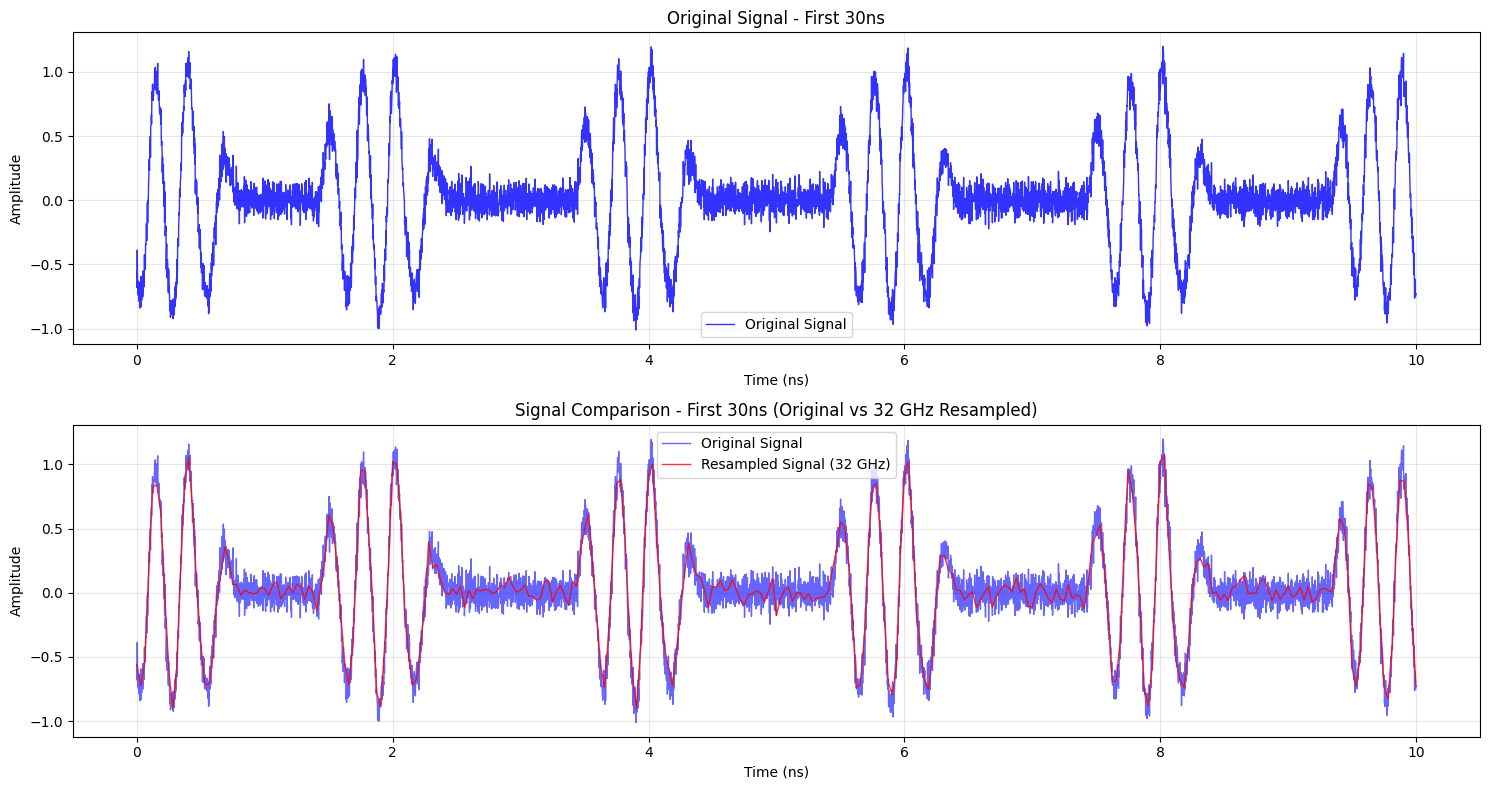


=== First 30ns Signal Statistics ===
Original signal points: 6535
Resampled signal points: 321
Original sampling rate: 652.14 GHz (estimated)
Resampled rate: 32.00 GHz


In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the target resampling frequency and interval
target_frequency_hz = config.signal.fs
resampling_interval_s = 1 / target_frequency_hz

# Read the CSV file, skipping the original header row to replace it later
# df = pd.read_csv(config.csv.awgn_t0, header=0)
df = df_awgn

# Rename columns for clarity based on the original header structure
# Assuming the first column is time-like and second is data-like
df.columns = ['original_time', 'original_data']

# Convert columns to numeric, coercing errors if any
df['original_time'] = pd.to_numeric(df['original_time'], errors='coerce')
df['original_data'] = pd.to_numeric(df['original_data'], errors='coerce')

# Drop rows with NaN values that might have resulted from coercion
df.dropna(subset=['original_time', 'original_data'], inplace=True)

# Prepare for resampling
# The new time axis will start from 0 (because df['original_time'] now starts from 0)
# and go up to the maximum duration of the adjusted time
start_resample_time = 0
end_resample_time = df['original_time'].max()

new_time_axis = np.arange(start_resample_time, end_resample_time, resampling_interval_s)

# Perform linear interpolation
# np.interp needs the original x-values (df['time']) to be sorted
# Assert that the data is already sorted by time
assert df['original_time'].is_monotonic_increasing, "Data must be sorted by time"
resampled_data_values = np.interp(new_time_axis, df['original_time'], df['original_data'])

# Create a new DataFrame for the resampled data
df_resampled = pd.DataFrame({'time': new_time_axis, 'data': resampled_data_values})

# Display the resampled data information without saving to file
print(f"Data resampled to {config.signal.fs_num} GHz.")
print(df_resampled.head())

# Display comparison of original and resampled signals for the first 30ns
time_limit = 1e-8  # 10 ns

# Filter data for the first 30ns
mask_original = df['original_time'] <= time_limit
mask_resampled = df_resampled['time'] <= time_limit

# Create comparison plot
plt.figure(figsize=(15, 8))

# Top plot: Original signal
plt.subplot(2, 1, 1)
plt.plot(df.loc[mask_original, 'original_time'] * 1e9, 
        df.loc[mask_original, 'original_data'], 
        'b-', linewidth=1, alpha=0.8, label='Original Signal')
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude')
plt.title('Original Signal - First 30ns')
plt.grid(True, alpha=0.3)
plt.legend()

# Bottom plot: Signal comparison
plt.subplot(2, 1, 2)
plt.plot(df.loc[mask_original, 'original_time'] * 1e9, 
        df.loc[mask_original, 'original_data'], 
        'b-', linewidth=1, alpha=0.6, label=f'Original Signal')
plt.plot(df_resampled.loc[mask_resampled, 'time'] * 1e9, 
        df_resampled.loc[mask_resampled, 'data'], 
        'r-', linewidth=1, alpha=0.8, label=f'Resampled Signal ({config.signal.fs_num} GHz)')
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude')
plt.title(f'Signal Comparison - First 30ns (Original vs {config.signal.fs_num} GHz Resampled)')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# Print statistics
print(f"\n=== First 30ns Signal Statistics ===")
print(f"Original signal points: {mask_original.sum()}")
print(f"Resampled signal points: {mask_resampled.sum()}")
print(f"Original sampling rate: {1/df['original_time'].diff().mean()/1e9:.2f} GHz (estimated)")
print(f"Resampled rate: {target_frequency_hz/1e9:.2f} GHz")

#

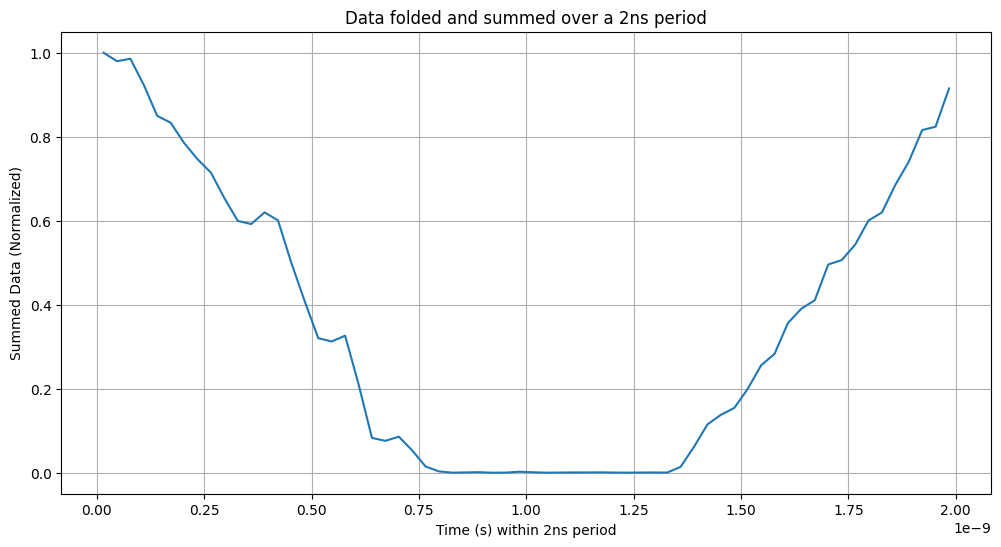

The midpoint of the interval where data is > 0.2 is: 7.8125e-11 s
Need to delay the signal by 1.9219e-09 s to align with the end of period.
This corresponds to 61 samples at 32 GHz sampling rate.


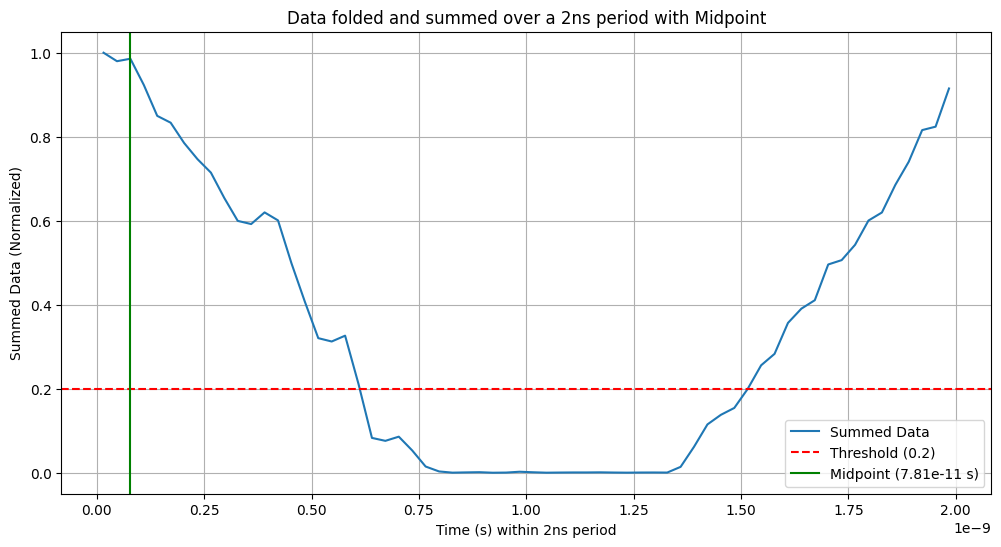

In [70]:
# Calculate the square of the data to find power
df_resampled['Data_Squared'] = df_resampled['data'] ** 2

# Define the period for folding (assuming 500 Mbps symbol rate -> 2 ns period)
period = 2e-9  # 2 ns

# Use the squared data for folding analysis
data_to_fold = df_resampled['Data_Squared'].dropna()
time_to_fold = df_resampled.loc[data_to_fold.index, 'time']

# Calculate the time modulo the period
folded_time = time_to_fold % period

# Determine the time resolution
time_resolution = time_to_fold.diff().mean()
if pd.isna(time_resolution):
    time_resolution = (df_resampled['time'].iloc[1] - df_resampled['time'].iloc[0]) if len(df_resampled['time']) > 1 else 1e-12

# Create bins for the 0-2ns range
num_bins = max(1, int(period / time_resolution))
bins = np.linspace(0, period, num_bins + 1)

# Create a dataframe for folding
fold_df = pd.DataFrame({'time': folded_time, 'data': data_to_fold})

# Digitize the folded time to assign each time point to a bin
fold_df['time_bin'] = pd.cut(fold_df['time'], bins=bins, labels=False, include_lowest=True)

# Group by the bins and sum the data
summed_data = fold_df.groupby('time_bin')['data'].sum()

# Create the time axis for the summed data (using the middle of each bin)
bin_centers = (bins[:-1] + bins[1:]) / 2

# Reindex the summed data to match the bins, filling missing bins with 0
summed_data = summed_data.reindex(range(len(bin_centers)), fill_value=0)

# Normalize the summed data to be between 0 and 1
summed_data = (summed_data - summed_data.min()) / (summed_data.max() - summed_data.min())

# Plot the folded result
plt.figure(figsize=(12, 6))
plt.plot(bin_centers, summed_data)
plt.xlabel('Time (s) within 2ns period')
plt.ylabel('Summed Data (Normalized)')
plt.title('Data folded and summed over a 2ns period')
plt.grid(True)
plt.show()

# Find the midpoint of the interval where data is above a threshold
threshold = 0.2

# Find where data is greater than threshold
above_threshold = summed_data > threshold

if above_threshold.any():
    # Get the time values for these points
    time_above_threshold = bin_centers[above_threshold]

    # Calculate the circular mean of the time points to handle wrap-around
    # Convert time to angles (radians)
    angles = (time_above_threshold / period) * 2 * np.pi

    # Compute the mean of the sines and cosines of the angles
    mean_sin = np.mean(np.sin(angles))
    mean_cos = np.mean(np.cos(angles))

    # Calculate the mean angle from the mean sine and cosine
    mean_angle = np.arctan2(mean_sin, mean_cos)

    # Convert the mean angle back to time
    midpoint_time = (mean_angle / (2 * np.pi)) * period

    # Adjust the midpoint to be in the [0, period] range
    if midpoint_time < 0:
        midpoint_time += period

    print(f"The midpoint of the interval where data is > {threshold} is: {midpoint_time:.4e} s")
    print(f"Need to delay the signal by {period - midpoint_time:.4e} s to align with the end of period.")
    print(f"This corresponds to {int((period - midpoint_time) * config.signal.fs)} samples at {config.signal.fs_num} GHz sampling rate.")

    # Plot the result with midpoint visualization
    plt.figure(figsize=(12, 6))
    plt.plot(bin_centers, summed_data, label='Summed Data')
    plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold})')
    plt.axvline(x=midpoint_time, color='g', linestyle='-', label=f'Midpoint ({midpoint_time:.2e} s)')
    plt.xlabel('Time (s) within 2ns period')
    plt.ylabel('Summed Data (Normalized)')
    plt.title('Data folded and summed over a 2ns period with Midpoint')
    plt.grid(True)
    plt.legend()
    plt.show()

else:
    print(f"No data points found above the threshold of {threshold}.")


Time threshold: 1.0781e-09 s
Number of data points to remove: 35
Original data shape: (160001, 3)
Trimmed data shape: (159966, 3)
Data points removed: 35
First few rows of trimmed data:
           time      data  Data_Squared
0  0.000000e+00  0.085762      0.007355
1  3.125000e-11 -0.049528      0.002453
2  6.250000e-11 -0.008669      0.000075
3  9.375000e-11  0.051236      0.002625
4  1.250000e-10 -0.003435      0.000012


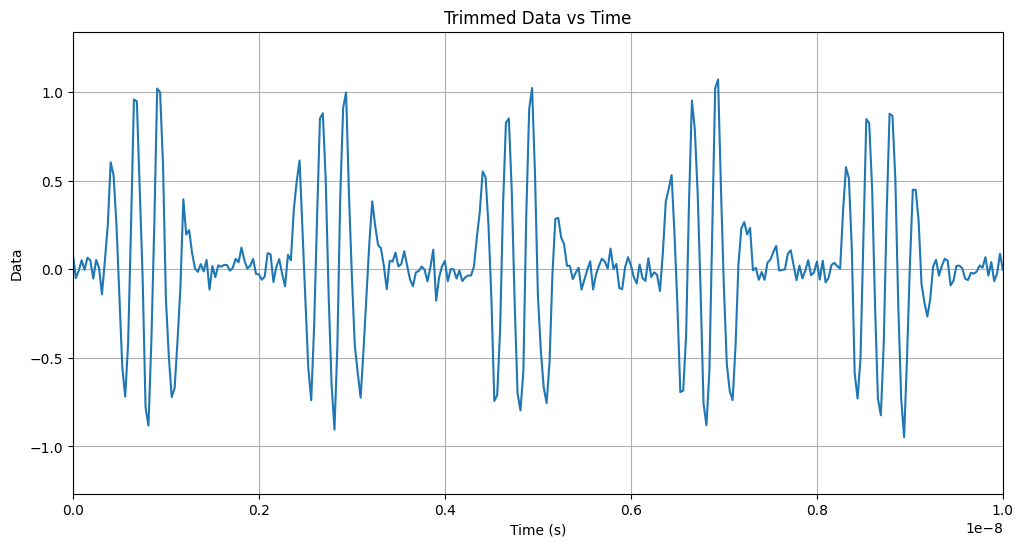

Trimmed data saved to ../csv/fs.csv
Saved data shape: (159966, 2)
Columns saved: ['time', 'data']


In [71]:
# Remove the first (midpoint_time + 1e-9) seconds of data
# Calculate the time threshold
time_threshold = midpoint_time + 1e-9  # Add 1 ns to midpoint_time

# Find the index where time first exceeds the threshold
indices_to_remove = df_resampled['time'] < time_threshold
num_points_to_remove = indices_to_remove.sum()

print(f"Time threshold: {time_threshold:.4e} s")
print(f"Number of data points to remove: {num_points_to_remove}")

# Create the trimmed dataframe
df_trimmed = df_resampled[~indices_to_remove].copy()

# Reset the time axis to start from 0 again
df_trimmed['time'] = df_trimmed['time'] - df_trimmed['time'].min()

# Reset the index
df_trimmed.reset_index(drop=True, inplace=True)

print(f"Original data shape: {df_resampled.shape}")
print(f"Trimmed data shape: {df_trimmed.shape}")
print(f"Data points removed: {df_resampled.shape[0] - df_trimmed.shape[0]}")
print(f"First few rows of trimmed data:")
print(df_trimmed.head())

# Plot the trimmed data
plt.figure(figsize=(12, 6))
plt.plot(df_trimmed['time'], df_trimmed['data'])
plt.xlabel('Time (s)')
plt.ylabel('Data')
plt.title('Trimmed Data vs Time')
plt.grid(True)
plt.xlim(0, 1e-8)  # Show 0-10 ns
# Set x-axis ticks every 2 ns
plt.xticks(np.arange(0, 1e-8 + 2e-9, 2e-9))
plt.show()

# Save the trimmed data to CSV file
# Only save time and data columns (exclude Data_Squared)
df_to_save = pd.DataFrame(df_trimmed[['time', 'data']])
# df_to_save.to_csv(config.csv.fs, index=False)
print(f"Trimmed data saved to {config.csv.fs}")
print(f"Saved data shape: {df_to_save.shape}")
print(f"Columns saved: {list(df_to_save.columns)}")

In [72]:
df_awgn = df_trimmed

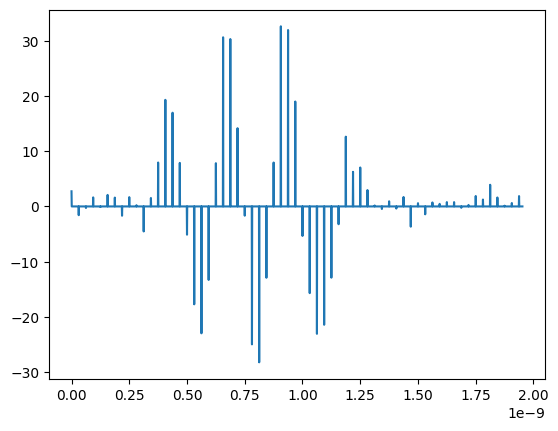

In [73]:
upsample_factor = int(config.signal.up_fs_num / config.signal.fs_num)

x_orig = df_awgn['data'].to_numpy(dtype=np.float64)
x_upsampled = np.zeros(x_orig.shape[0] * upsample_factor)
x_upsampled[::upsample_factor] = x_orig * upsample_factor

Ts_orig = 1 / config.signal.fs  # Original sampling period
Ts_upsampled = Ts_orig / upsample_factor  # New sampling period
t_upsampled = np.arange(len(x_upsampled), dtype=np.float64) * Ts_upsampled

df_upsampled = pd.DataFrame({
    'time': t_upsampled,
    'data': x_upsampled
})

plt.plot(df_upsampled['time'][:2000], df_upsampled['data'][:2000])
plt.show()

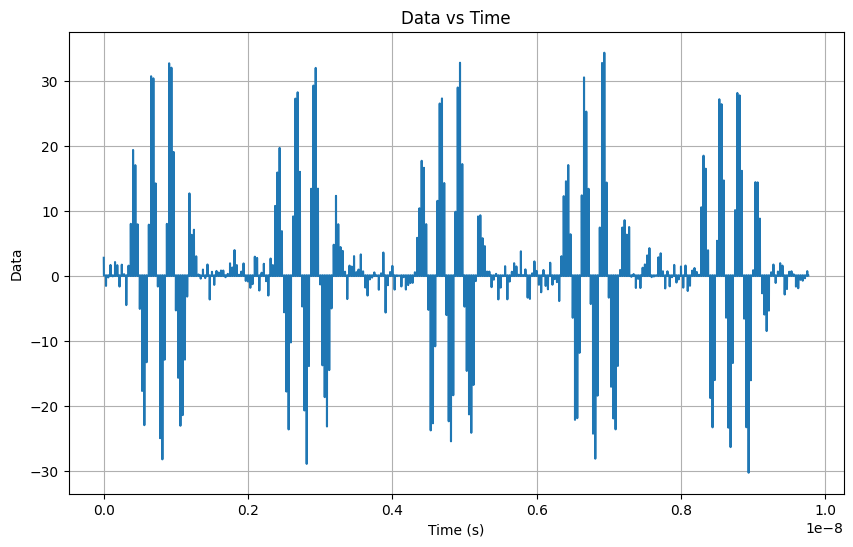

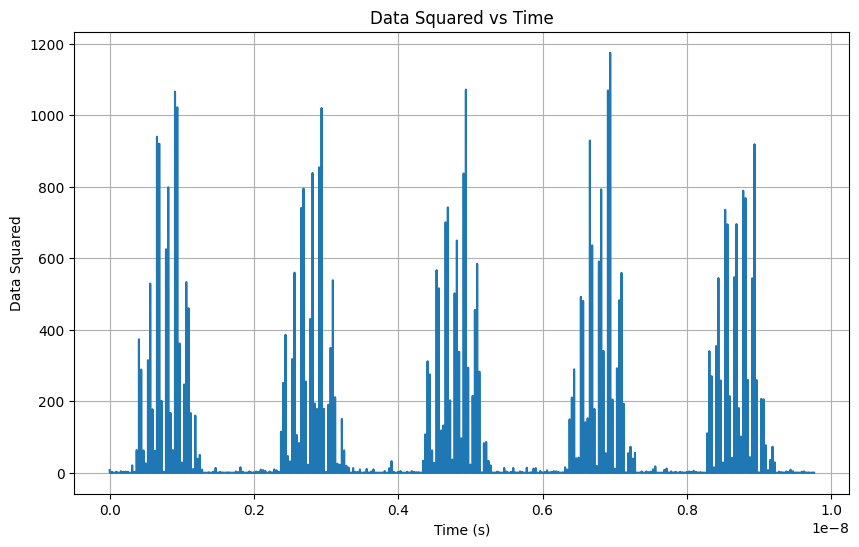

In [74]:
# df = pd.read_csv(config.csv.up_fs)
# print(f"Reading file: {config.csv.up_fs}")  # Add this line to confirm which file is being read
df = df_upsampled

# Plot Data column vs Time
plt.figure(figsize=(10, 6))
plt.plot(df['time'][:10000], df['data'][:10000])
plt.xlabel('Time (s)')
plt.ylabel('Data')
plt.title('Data vs Time')
plt.grid(True)
plt.show()

# Calculate the square of the data
df['Data_Squared'] = df['data'] ** 2
plt.figure(figsize=(10, 6))
plt.plot(df['time'][:10000], df['Data_Squared'][:10000])
plt.xlabel('Time (s)')
plt.ylabel('Data Squared')
plt.title('Data Squared vs Time')
plt.grid(True)
plt.show()

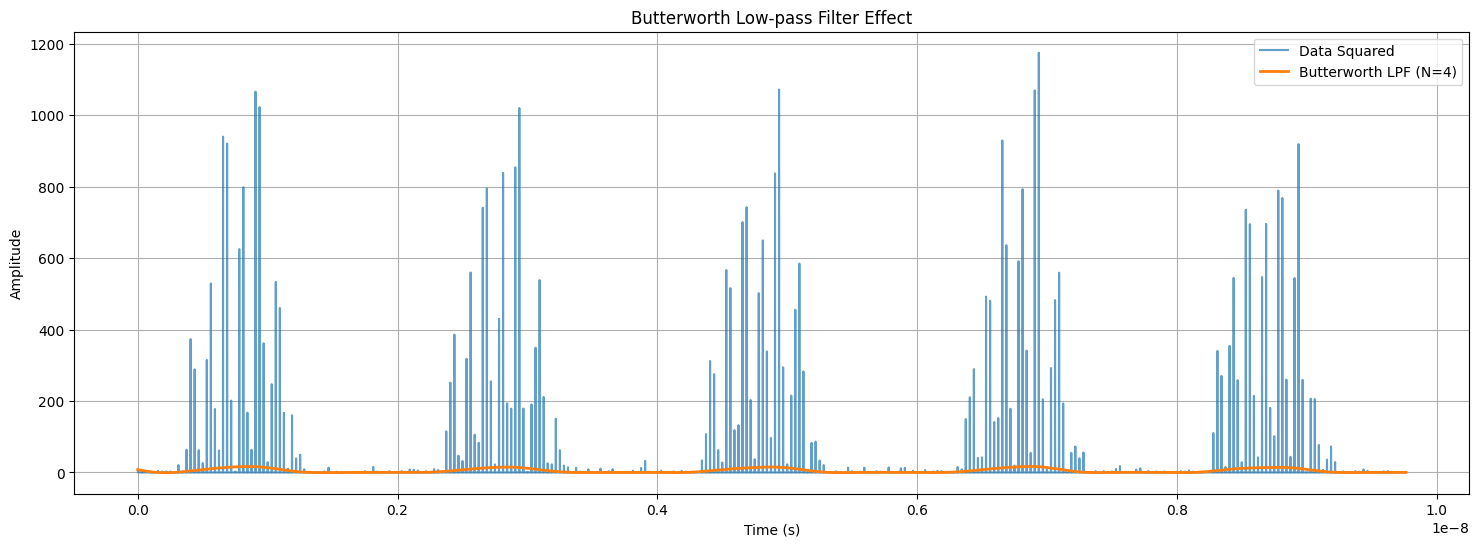

In [75]:
# Butterworth low-pass filter parameters
native_sampling_rate = config.signal.up_fs  # Use the upsampled frequency
cutoff = 2e9  # 4 GHz cutoff frequency
N = 4  # Filter order
nyq = native_sampling_rate / 2
cutoff_norm = cutoff / nyq

# Design Butterworth filter
b, a = sp.signal.butter(N, cutoff_norm, btype='low')

# Apply zero-phase filtering
df['Data_MA'] = sp.signal.filtfilt(b, a, df['Data_Squared'])

plt.figure(figsize=(18, 6))
plt.plot(df['time'][:10000], df['Data_Squared'][:10000], label='Data Squared', alpha=0.7)
plt.plot(df['time'][:10000], df['Data_MA'][:10000], label=f'Butterworth LPF (N={N})', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Butterworth Low-pass Filter Effect')
plt.legend()
plt.grid(True)
plt.show()

Found 2500 rising edges
Found 2500 falling edges
Found 2499 valid midpoints between rising and falling edges
First 20 midpoint times: [7.91992188e-10 2.78515625e-09 4.78417969e-09 6.78515625e-09
 8.68457031e-09 1.10830078e-08 1.31386719e-08 1.47714844e-08
 1.67695313e-08 1.87529297e-08 2.08291016e-08 2.31826172e-08
 2.48417969e-08 2.70996094e-08 2.86943359e-08 3.07050781e-08
 3.28144531e-08 3.52275391e-08 3.71835937e-08 3.92177734e-08]


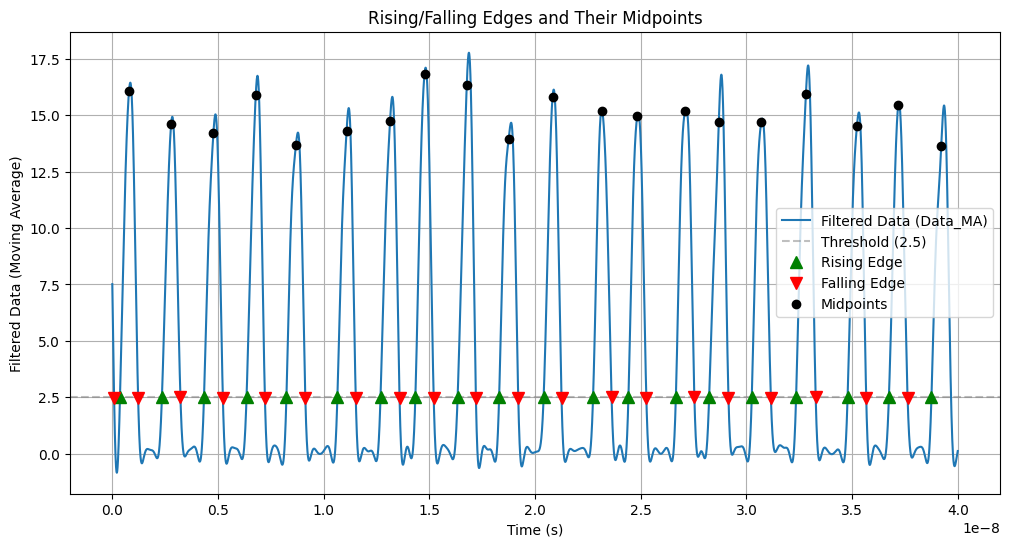

In [76]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

# Set threshold
threshold = 2.5
native_sampling_rate = config.signal.up_fs  # Use the upsampled frequency
symbol_rate = config.signal.fsymbol  # 500 MHz

# Get data
filtered_data = df["Data_MA"].values

# Calculate both rising and falling edges
above = filtered_data > threshold
rising_edges = np.where(np.diff(above.astype(int)) == 1)[0] + 1   # Rising edges
falling_edges = np.where(np.diff(above.astype(int)) == -1)[0] + 1  # Falling edges

print(f"Found {len(rising_edges)} rising edges")
print(f"Found {len(falling_edges)} falling edges")

# Calculate midpoints between rising and falling edges
mid_indices = []
mid_times = []

if rising_edges.size > 0 and falling_edges.size > 0:
    # Find pairs of rising and falling edges to calculate midpoints
    i_rising = 0
    i_falling = 0
    
    while i_rising < len(rising_edges) and i_falling < len(falling_edges):
        rise_idx = rising_edges[i_rising]
        fall_idx = falling_edges[i_falling]
        
        # Find the next falling edge after the current rising edge
        if fall_idx > rise_idx:
            # Calculate midpoint between this rising edge and falling edge
            midpoint_idx = int((rise_idx + fall_idx) / 2)
            mid_indices.append(midpoint_idx)
            mid_times.append(df.loc[midpoint_idx, 'time'])
            i_rising += 1
            i_falling += 1
        else:
            # This falling edge is before the current rising edge, skip it
            i_falling += 1
    
    mid_indices = np.array(mid_indices)
    mid_times = np.array(mid_times)
    
    print(f"Found {len(mid_indices)} valid midpoints between rising and falling edges")
    if len(mid_times) > 0:
        print(f"First 20 midpoint times: {mid_times[:20]}")
else:
    mid_indices = np.array([])
    mid_times = np.array([])
    print("No rising/falling edge pairs detected")

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(df['time'][:20480*2], df['Data_MA'][:20480*2], label='Filtered Data (Data_MA)')
plt.axhline(y=threshold, color='gray', linestyle='--', alpha=0.5, label=f'Threshold ({threshold})')

if rising_edges.size > 0:
    plt.plot(df.loc[rising_edges, 'time'][:20], filtered_data[rising_edges][:20], '^g', markersize=8, label='Rising Edge')
if falling_edges.size > 0:
    plt.plot(df.loc[falling_edges, 'time'][:20], filtered_data[falling_edges][:20], 'vr', markersize=8, label='Falling Edge')
if mid_indices.size > 0:
    plt.plot(df.loc[mid_indices, 'time'][:20], filtered_data[mid_indices][:20], 'ko', markersize=6, label='Midpoints')

plt.xlabel('Time (s)')
plt.ylabel('Filtered Data (Moving Average)')
plt.title('Rising/Falling Edges and Their Midpoints')
plt.grid(True)
plt.legend()
plt.show()


Mid Point Analysis Results:
Number of mid points found: 2499
Mid indices: [811, 2852, 4899, 6948, 8893, 11349, 13454, 15126, 17172, 19203, 21329, 23739, 25438, 27750, 29383, 31442, 33602, 36073, 38076, 40159, 42219, 43866, 45835, 48212, 49988, 52072, 53982, 56455, 58193, 60482, 62569, 64235, 66399, 68829, 70870, 72827, 74575, 77028, 78605, 80978, 82771, 84734, 87127, 89176, 91370, 93265, 95340, 97128, 99460, 101117, 103121, 105164, 107291, 109649, 111724, 113864, 115495, 117545, 119478, 122064, 123693, 125769, 128091, 129748, 131917, 134362, 136292, 138023, 140510, 142580, 144150, 146507, 148246, 150634, 152811, 154328, 156919, 158781, 161009, 162973, 164699, 167093, 169035, 170707, 172883, 174818, 177227, 179434, 180929, 183418, 185074, 187224, 189576, 191324, 193718, 195802, 197863, 199443, 201905, 203900, 206068, 207717, 209614, 212196, 214196, 215815, 217948, 220232, 221981, 224354, 226071, 228579, 230132, 232595, 234587, 236656, 238680, 240736, 242908, 244910, 246539, 248551, 2505

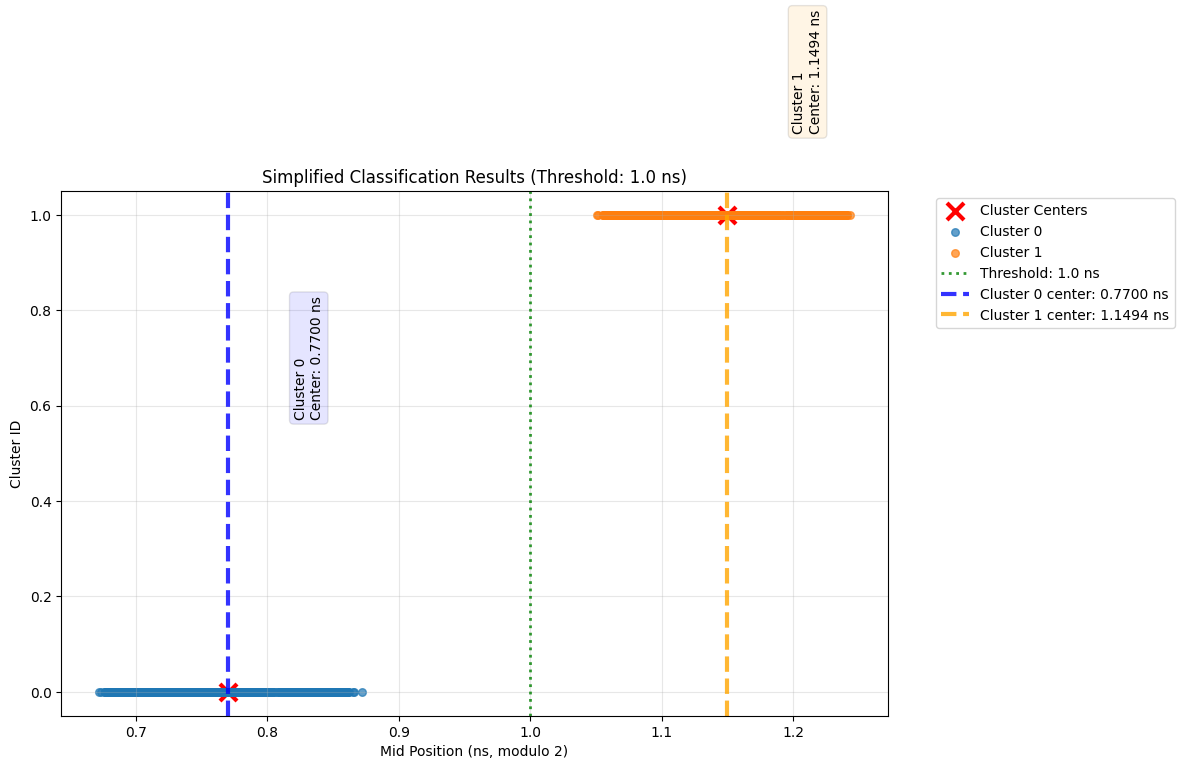

In [77]:
# Simplified classification logic: directly use 1ns as boundary
import numpy as np
import matplotlib.pyplot as plt

# Configuration parameters
THRESHOLD_NS = 1.0  # 1ns threshold for classification

# Extract mid positions from the previous analysis
if 'mid_indices' in locals() and 'mid_times' in locals():
    # List of mid indices in the dataframe
    mid_indices_list = mid_indices.tolist()
    
    # List of mid time positions
    mid_positions = mid_times.tolist()
    
    print("Mid Point Analysis Results:")
    print(f"Number of mid points found: {len(mid_positions)}")
    print(f"Mid indices: {mid_indices_list}")
    print(f"Mid time positions (seconds): {mid_positions}")
    
    # Convert to more readable format (nanoseconds)
    mid_positions_ns = [pos * 1e9 for pos in mid_positions]
    print(f"Mid time positions (nanoseconds): {mid_positions_ns}")
    
    # Calculate relative positions from the first mid point
    if len(mid_positions) > 1:
        relative_positions = [(pos - mid_positions[0]) * 1e9 for pos in mid_positions]
        print(f"Relative positions from first mid point (ns): {relative_positions}")
        
        # Calculate intervals between consecutive mid points
        intervals_ns = [pos * 1e9 for pos in np.diff(mid_positions)]
        print(f"Intervals between consecutive mid points (ns): {intervals_ns}")
        
    # Simplified classification: using fixed threshold 1ns
    if len(mid_positions_ns) > 0:
        # Calculate positions after modulo 2ns
        mid_positions_mod = np.array([pos % 2 for pos in mid_positions_ns])
        
        # Directly use 1ns as threshold for classification
        cluster_labels = np.where(mid_positions_mod < THRESHOLD_NS, 0, 1)
        
        # Calculate center position of each cluster
        cluster_0_positions = mid_positions_mod[cluster_labels == 0]
        cluster_1_positions = mid_positions_mod[cluster_labels == 1]
        
        if len(cluster_0_positions) > 0:
            # Calculate the average of 5th and 95th percentiles as cluster center
            p5 = np.percentile(cluster_0_positions, 5)
            p95 = np.percentile(cluster_0_positions, 95)
            first_cluster_center = (p5 + p95) / 2
        else:
            first_cluster_center = 0.5  # Default value
            
        if len(cluster_1_positions) > 0:
            # Calculate the average of 5th and 95th percentiles as cluster center
            p5 = np.percentile(cluster_1_positions, 5)
            p95 = np.percentile(cluster_1_positions, 95)
            second_cluster_center = (p5 + p95) / 2
        else:
            second_cluster_center = 1.5  # Default value
            
        sorted_centers = [first_cluster_center, second_cluster_center]
        
        print(f"\n=== Simplified Classification Results (Threshold: {THRESHOLD_NS} ns) ===")
        cluster_0_count = np.sum(cluster_labels == 0)
        cluster_1_count = np.sum(cluster_labels == 1)
        print(f"Cluster 0: Time = {first_cluster_center:.4f} ns (modulo 2), Points = {cluster_0_count}")
        print(f"Cluster 1: Time = {second_cluster_center:.4f} ns (modulo 2), Points = {cluster_1_count}")
        
        # Maintain output format compatible with original code
        print(f"\nCluster centers in picoseconds (time sorted): [{first_cluster_center * 1000:.2f} {second_cluster_center * 1000:.2f}]")
        print(f"\nCluster centers in nanoseconds (time sorted): [{first_cluster_center:.8f} {second_cluster_center:.8f}]")

        print(f"\n=== Cluster Position Analysis ===")
        print(f"Position of cluster 0: {first_cluster_center:.6f} ns")
        print(f"Position of cluster 1: {second_cluster_center:.6f} ns")
        print(f"Difference between the two clusters: {second_cluster_center - first_cluster_center:.6f} ns")
        
        # Also show in picoseconds
        print(f"\nPosition of cluster 0: {first_cluster_center * 1000:.2f} ps")
        print(f"Position of cluster 1: {second_cluster_center * 1000:.2f} ps")
        print(f"Difference between the two clusters: {(second_cluster_center - first_cluster_center) * 1000:.2f} ps")

        # Visualize classification results
        plt.figure(figsize=(12, 8))
        # Generate colors for clusters
        colors = ['#1f77b4', '#ff7f0e']

        # Plot cluster centers
        plt.scatter(sorted_centers, range(2), color='red', marker='x', s=150, 
                   linewidths=3, label='Cluster Centers')
        
        # Plot cluster points
        for i in range(2):
            cluster_points = mid_positions_mod[cluster_labels == i]
            plt.scatter(cluster_points, np.ones(len(cluster_points)) * i, 
                       color=colors[i % len(colors)], alpha=0.7, s=30, label=f'Cluster {i}')
        
        # Add vertical line for threshold
        plt.axvline(x=THRESHOLD_NS, color='green', linestyle=':', linewidth=2, alpha=0.8, 
                   label=f'Threshold: {THRESHOLD_NS} ns')
        
        # Add vertical lines for cluster centers
        plt.axvline(x=float(first_cluster_center), color='blue', linestyle='--', linewidth=3, alpha=0.8, 
                   label=f'Cluster 0 center: {first_cluster_center:.4f} ns')
        plt.axvline(x=float(second_cluster_center), color='orange', linestyle='--', linewidth=3, alpha=0.8, 
                   label=f'Cluster 1 center: {second_cluster_center:.4f} ns')
        
        # Add text annotations for the cluster centers
        plt.text(float(first_cluster_center) + 0.05, 0.7, f'Cluster 0\nCenter: {first_cluster_center:.4f} ns', 
                rotation=90, verticalalignment='center', fontsize=10, 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='blue', alpha=0.1))
        plt.text(float(second_cluster_center) + 0.05, 1.3, f'Cluster 1\nCenter: {second_cluster_center:.4f} ns', 
                rotation=90, verticalalignment='center', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='orange', alpha=0.1))
        
        plt.xlabel('Mid Position (ns, modulo 2)')
        plt.ylabel('Cluster ID')
        plt.title(f'Simplified Classification Results (Threshold: {THRESHOLD_NS} ns)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
    else:
        print(f"No mid points found for classification")
        
else:
    print("Please run the mid point detection cell first to generate mid point data.")



=== Symbol Classification ===

=== Data Reshaping and Symbol Alignment ===
Original signal length: 5118912
Samples per symbol: 2048
Trimmed signal length: 5117952
Frames shape: (2499, 2048)
Symbol center position: 1024
Cluster 0 position (samples): 788.53
Cluster 1 position (samples): 1177.00
Cluster 0 needs to move: 235 samples (right shift)
Cluster 1 needs to move: -150 samples (left shift)
Symbol alignment completed, aligned frames shape: (2499, 2048)


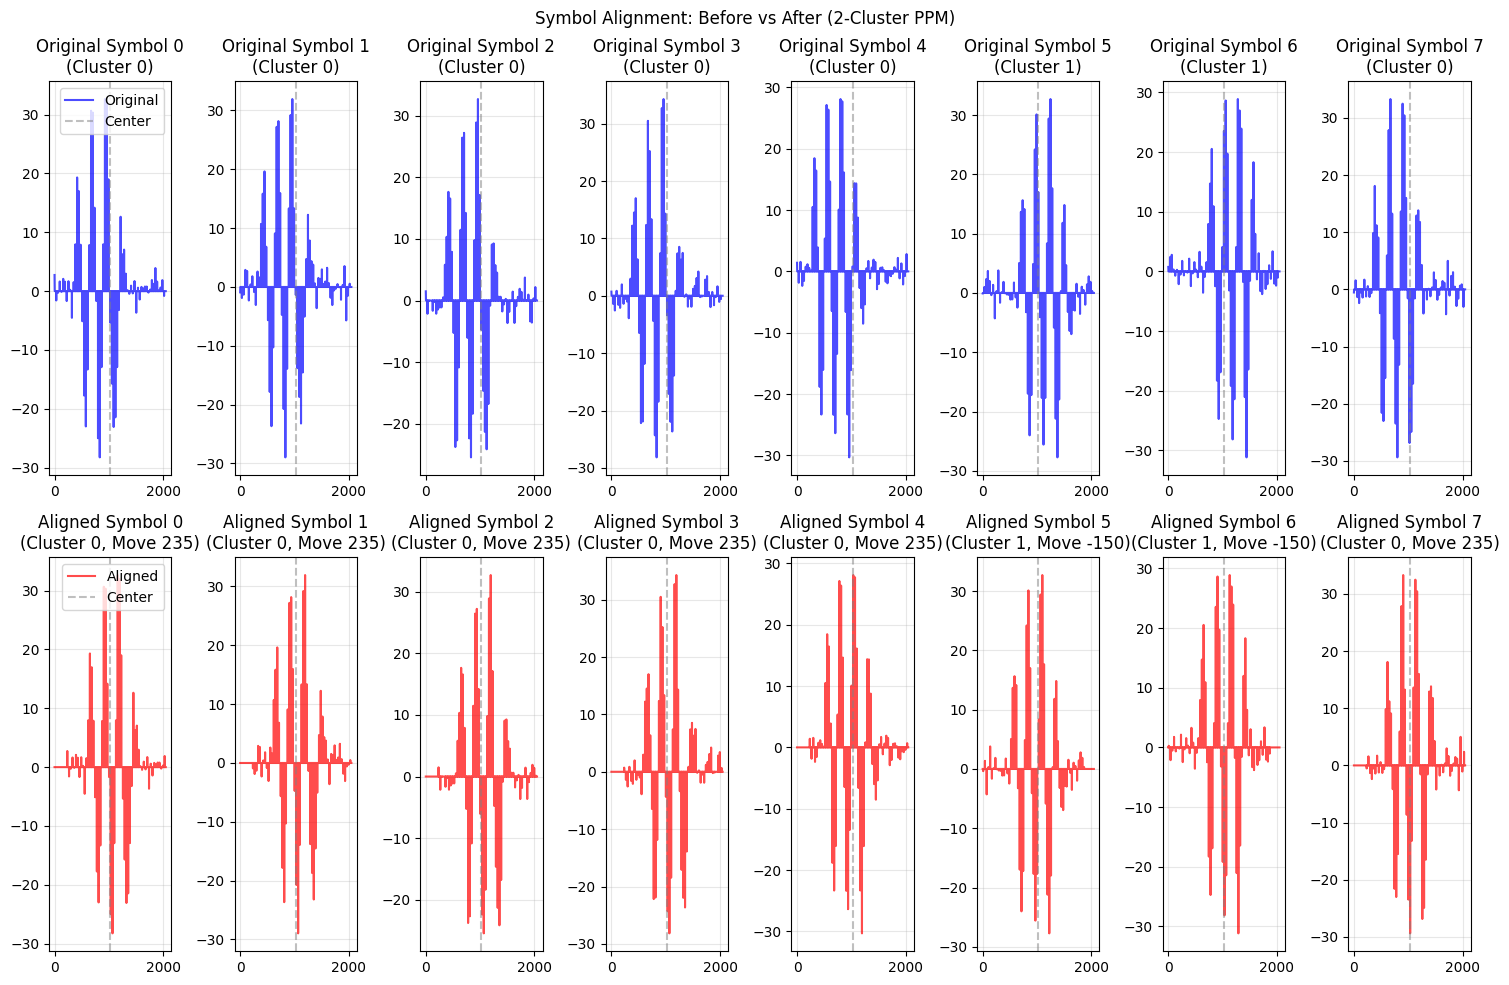

Total detected symbols: 2499
Cluster 0: 1242 symbols (49.7%)
Cluster 1: 1257 symbols (50.3%)

Classification results for first 50 symbols:
Symbol indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Classifications: [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0]


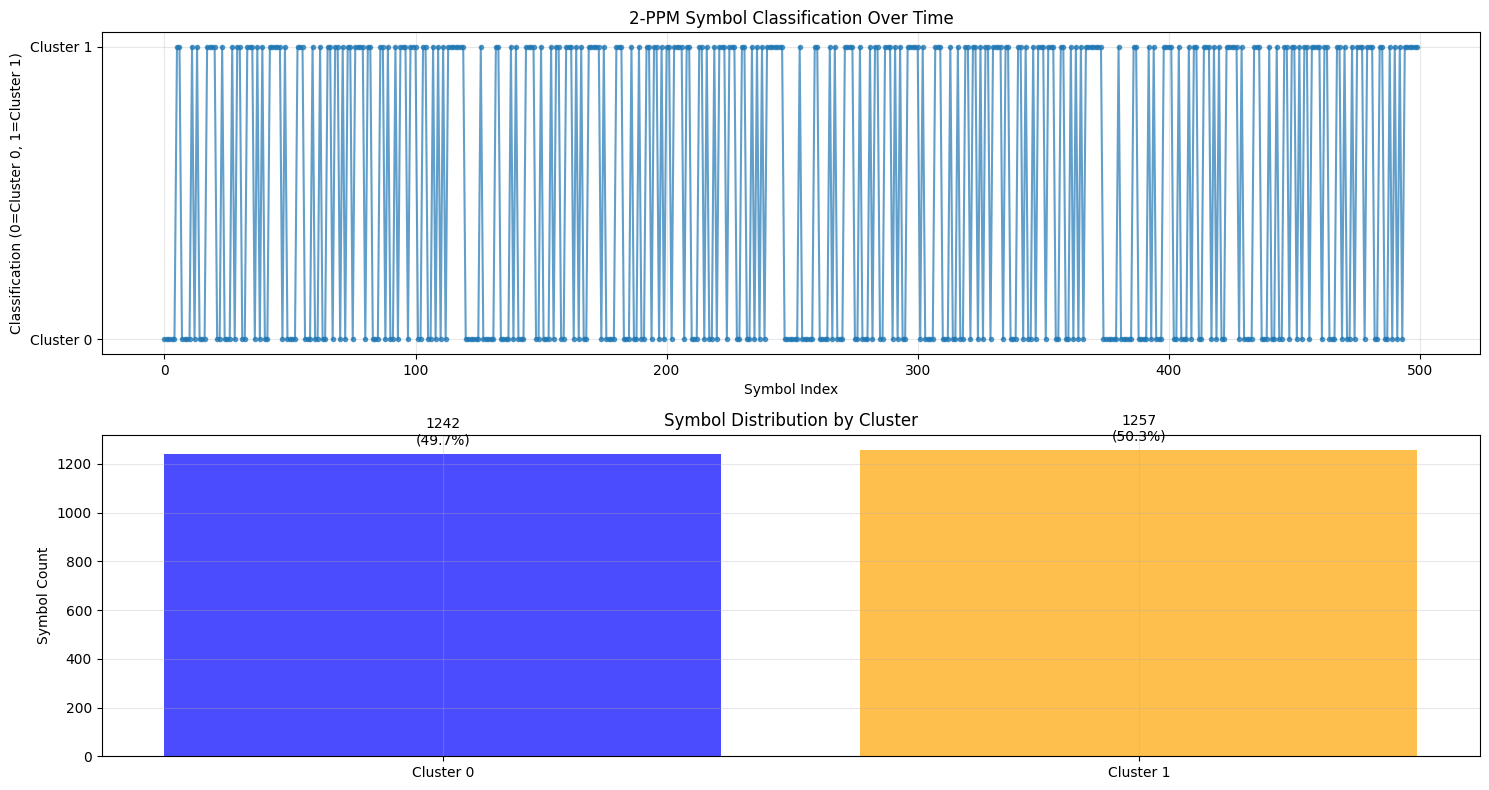


Demodulated bit sequence (first 100 bits): [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1]

Statistics:
Total transitions: 1258
Transition rate: 50.4%


In [78]:
# Symbol classification and alignment for 2-cluster PPM demodulation

# Symbol classification based on 2 clusters
print(f"\n=== Symbol Classification ===")

# Direct classification: cluster 0 = bit 0, cluster 1 = bit 1
symbol_classifications = cluster_labels

# Data reshaping and symbol alignment
print(f"\n=== Data Reshaping and Symbol Alignment ===")

# Get original signal data and parameters
ori_signal = df['data'].values
ori_len = len(ori_signal)
samples_per_frame = int(config.signal.up_fs / config.signal.fsymbol)

# Reshape data into frames
trimmed_len = ori_len - (ori_len % samples_per_frame)
trimmed_signal = ori_signal[:trimmed_len]
frames = trimmed_signal.reshape(-1, samples_per_frame)

print(f"Original signal length: {ori_len}")
print(f"Samples per symbol: {samples_per_frame}")
print(f"Trimmed signal length: {trimmed_len}")
print(f"Frames shape: {frames.shape}")

# Calculate symbol center and offsets
symbol_center = samples_per_frame // 2

# Convert cluster positions from nanoseconds to sample indices
sampling_period = 1 / config.signal.up_fs  # seconds per sample
cluster_0_samples = first_cluster_center * 1e-9 / sampling_period  # convert ns to samples
cluster_1_samples = second_cluster_center * 1e-9 / sampling_period   # convert ns to samples

# Calculate shifts needed to center each cluster
x0 = int(round(symbol_center - cluster_0_samples))  # shift for cluster 0 (right shift if positive)
x1 = int(round(symbol_center - cluster_1_samples))  # shift for cluster 1 (right shift if positive)
adjust_offset = 3
x1 += adjust_offset

# print(x0, x1)  # 214， -170
# x0, x1 = 214, -174

print(f"Symbol center position: {symbol_center}")
print(f"Cluster 0 position (samples): {cluster_0_samples:.2f}")
print(f"Cluster 1 position (samples): {cluster_1_samples:.2f}")
print(f"Cluster 0 needs to move: {x0} samples ({'right shift' if x0 > 0 else 'left shift' if x0 < 0 else 'no movement'})")
print(f"Cluster 1 needs to move: {x1} samples ({'right shift' if x1 > 0 else 'left shift' if x1 < 0 else 'no movement'})")

# Apply shifts to each frame based on classification
aligned_frames = np.zeros_like(frames)

for i in range(len(frames)):
    if i < len(symbol_classifications):  # Ensure we have classification for this frame
        if symbol_classifications[i] == 0:  # Cluster 0
            shift = x0
        else:  # Cluster 1
            shift = x1
        
        # Apply the calculated shift
        if shift > 0:  # Right shift
            aligned_frames[i, shift:] = frames[i, :-shift]
            aligned_frames[i, :shift] = 0  # Fill with zeros
        elif shift < 0:  # Left shift
            aligned_frames[i, :shift] = frames[i, -shift:]
            aligned_frames[i, shift:] = 0  # Fill with zeros
        else:  # No shift needed
            aligned_frames[i] = frames[i]
    else:
        aligned_frames[i] = frames[i]  # No classification available, keep original

print(f"Symbol alignment completed, aligned frames shape: {aligned_frames.shape}")

# Visualize the alignment effect
plt.figure(figsize=(15, 10))

# Show first few symbols before and after alignment
num_examples = min(8, len(frames))

for i in range(num_examples):
    # Original frames
    plt.subplot(2, num_examples, i+1)
    plt.plot(frames[i], 'b-', alpha=0.7, label='Original')
    plt.axvline(x=symbol_center, color='gray', linestyle='--', alpha=0.5, label='Center')
    if i < len(symbol_classifications):
        cluster_name = f'Cluster {symbol_classifications[i]}'
        plt.title(f'Original Symbol {i}\n({cluster_name})')
    plt.grid(True, alpha=0.3)
    if i == 0:
        plt.legend()
    
    # Aligned frames
    plt.subplot(2, num_examples, i+1+num_examples)
    plt.plot(aligned_frames[i], 'r-', alpha=0.7, label='Aligned')
    plt.axvline(x=symbol_center, color='gray', linestyle='--', alpha=0.5, label='Center')
    if i < len(symbol_classifications):
        cluster_name = f'Cluster {symbol_classifications[i]}'
        shift = x0 if symbol_classifications[i] == 0 else x1
        shift_info = f'Move {shift}' if shift != 0 else 'No movement'
        plt.title(f'Aligned Symbol {i}\n({cluster_name}, {shift_info})')
    plt.grid(True, alpha=0.3)
    if i == 0:
        plt.legend()

plt.suptitle('Symbol Alignment: Before vs After (2-Cluster PPM)')
plt.tight_layout()
plt.show()

# Count symbols in each cluster
cluster_0_count = np.sum(symbol_classifications == 0)
cluster_1_count = np.sum(symbol_classifications == 1)
total_symbols = len(symbol_classifications)

print(f"Total detected symbols: {total_symbols}")
print(f"Cluster 0: {cluster_0_count} symbols ({cluster_0_count/total_symbols*100:.1f}%)")
print(f"Cluster 1: {cluster_1_count} symbols ({cluster_1_count/total_symbols*100:.1f}%)")

# Show first 50 classifications
print(f"\nClassification results for first 50 symbols:")
print(f"Symbol indices: {list(range(min(50, len(symbol_classifications))))}")
print(f"Classifications: {symbol_classifications[:50].tolist()}")

# Create a visualization of symbol classifications over time
plt.figure(figsize=(15, 8))

# Plot 1: Symbol classification over time
plt.subplot(2, 1, 1)
plt.plot(range(500), symbol_classifications[:500], 'o-', markersize=3, alpha=0.7)
plt.xlabel('Symbol Index')
plt.ylabel('Classification (0=Cluster 0, 1=Cluster 1)')
plt.title('2-PPM Symbol Classification Over Time')
plt.grid(True, alpha=0.3)
plt.yticks([0, 1], ['Cluster 0', 'Cluster 1'])

# Plot 2: Histogram of classifications
plt.subplot(2, 1, 2)
plt.bar(['Cluster 0', 'Cluster 1'], 
        [cluster_0_count, cluster_1_count], 
        color=['blue', 'orange'], alpha=0.7)
plt.ylabel('Symbol Count')
plt.title('Symbol Distribution by Cluster')
plt.grid(True, alpha=0.3)

# Add count labels on bars
plt.text(0, cluster_0_count + total_symbols*0.01, f'{cluster_0_count}\n({cluster_0_count/total_symbols*100:.1f}%)', 
        ha='center', va='bottom')
plt.text(1, cluster_1_count + total_symbols*0.01, f'{cluster_1_count}\n({cluster_1_count/total_symbols*100:.1f}%)', 
        ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Calculate bit sequence (direct mapping: cluster 0 -> bit 0, cluster 1 -> bit 1)
bit_sequence = symbol_classifications
print(f"\nDemodulated bit sequence (first 100 bits): {bit_sequence[:100].tolist()}")
# pd.DataFrame(bit_sequence, columns=['ppm_bit']).to_csv('bit_sequence.csv', index=False)

# Calculate transition statistics
transitions = np.diff(symbol_classifications)
num_transitions = np.sum(transitions != 0)
print(f"\nStatistics:")
print(f"Total transitions: {num_transitions}")
print(f"Transition rate: {num_transitions/(len(symbol_classifications)-1)*100:.1f}%")

## IQ demodulation

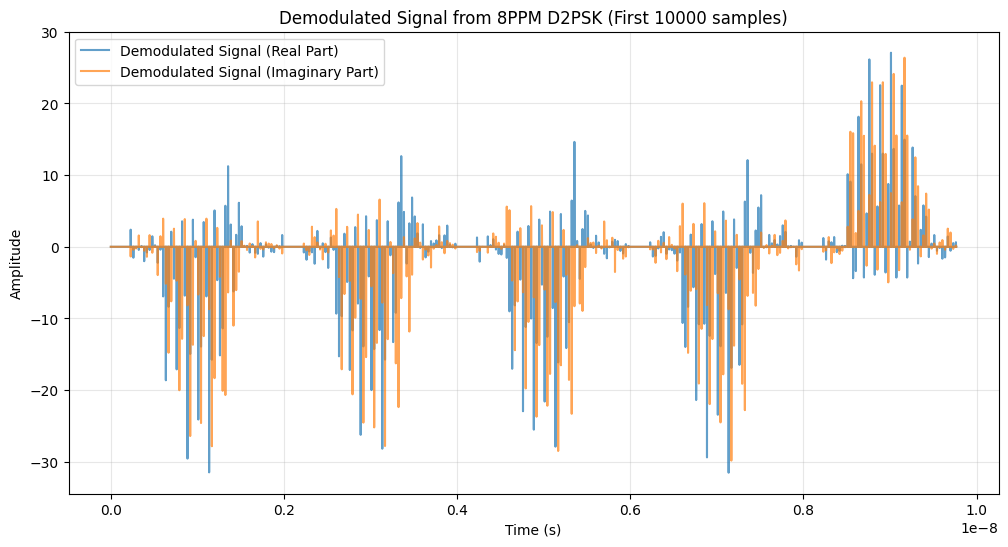

In [79]:
samples_per_frame = round(config.signal.up_fs / config.signal.fsymbol)

t_one_frame = np.linspace(0, 1/config.signal.fsymbol, samples_per_frame, endpoint=False)
cosine_wave = np.cos(2 * np.pi * config.signal.fc * t_one_frame)
sine_wave = np.sin(2 * np.pi * config.signal.fc * t_one_frame)

ori_signal = df['data'].values
ori_len = df['data'].size

demod_signal = cosine_wave * aligned_frames + sine_wave * aligned_frames * 1j
demod_signal = demod_signal.flatten()

# Plot the demodulated signal (first 10000 samples)
plt.figure(figsize=(12, 6))
plt.plot(df['time'][:10000], demod_signal.real[:10000], label='Demodulated Signal (Real Part)', alpha=0.7)
plt.plot(df['time'][:10000], demod_signal.imag[:10000], label='Demodulated Signal (Imaginary Part)', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Demodulated Signal from 8PPM D2PSK (First 10000 samples)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

Applied lowpass filter with cutoff frequency: 2.0 GHz
Filter order: 4
Sampling rate: 1024.0 GHz
Normalized cutoff: 0.0039


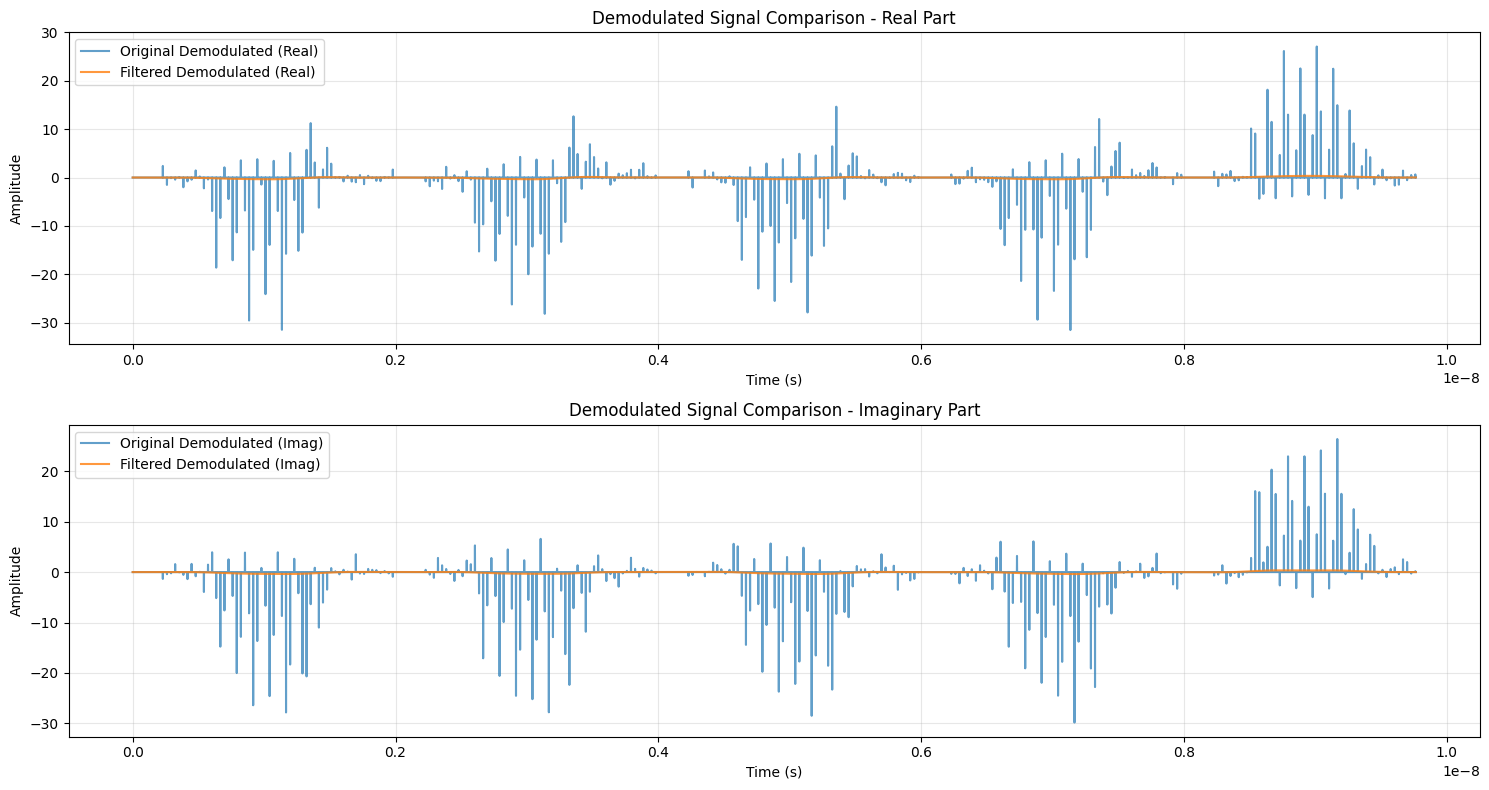

In [80]:
# Apply lowpass filter to the demodulated signal
from scipy import signal

# Filter parameters
cutoff_freq = 2e9  # 2 GHz cutoff frequency
sampling_rate = config.signal.up_fs  # Use the upsampled frequency
nyq = sampling_rate / 2
normalized_cutoff = cutoff_freq / nyq

# Design Butterworth lowpass filter
filter_order = 4
b, a = signal.butter(filter_order, normalized_cutoff, btype='low')

# Apply zero-phase filtering to both real and imaginary parts
demod_signal_filtered = np.zeros_like(demod_signal, dtype=complex)
demod_signal_filtered.real = signal.filtfilt(b, a, demod_signal.real)
demod_signal_filtered.imag = signal.filtfilt(b, a, demod_signal.imag)

print(f"Applied lowpass filter with cutoff frequency: {cutoff_freq/1e9:.1f} GHz")
print(f"Filter order: {filter_order}")
print(f"Sampling rate: {sampling_rate/1e9:.1f} GHz")
print(f"Normalized cutoff: {normalized_cutoff:.4f}")

# Plot comparison between original and filtered demodulated signal
plt.figure(figsize=(15, 8))

# Plot 1: Real part comparison
plt.subplot(2, 1, 1)
plt.plot(df['time'][:10000], demod_signal.real[:10000], label='Original Demodulated (Real)', alpha=0.7)
plt.plot(df['time'][:10000], demod_signal_filtered.real[:10000], label='Filtered Demodulated (Real)', alpha=0.8)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Demodulated Signal Comparison - Real Part')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot 2: Imaginary part comparison
plt.subplot(2, 1, 2)
plt.plot(df['time'][:10000], demod_signal.imag[:10000], label='Original Demodulated (Imag)', alpha=0.7)
plt.plot(df['time'][:10000], demod_signal_filtered.imag[:10000], label='Filtered Demodulated (Imag)', alpha=0.8)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Demodulated Signal Comparison - Imaginary Part')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

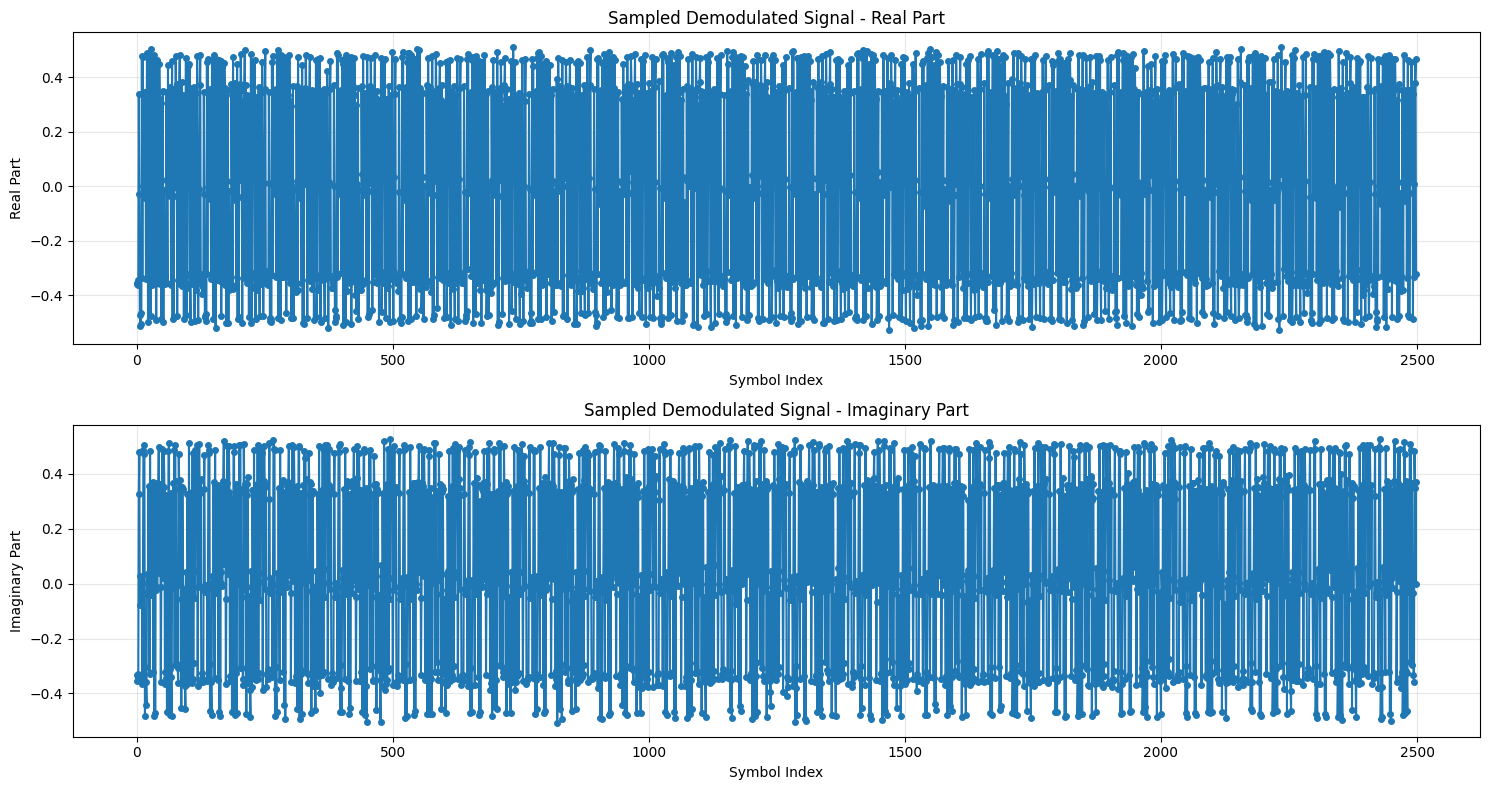

Sampled signal shape: (2499,)
Number of symbols: 2499


In [81]:
demod_signal_filtered = demod_signal_filtered.reshape(-1, samples_per_frame)

# Extract the sampled signal at the specified indices
sampled_signal = demod_signal_filtered[:, 1024].flatten()  # Take the 1024th frame and flatten it
# Plot the sampled signal
plt.figure(figsize=(15, 8))

# Plot real part
plt.subplot(2, 1, 1)
plt.plot(range(len(sampled_signal)), sampled_signal.real, 'o-', markersize=4)
plt.xlabel('Symbol Index')
plt.ylabel('Real Part')
plt.title('Sampled Demodulated Signal - Real Part')
plt.grid(True, alpha=0.3)

# Plot imaginary part
plt.subplot(2, 1, 2)
plt.plot(range(len(sampled_signal)), sampled_signal.imag, 'o-', markersize=4)
plt.xlabel('Symbol Index')
plt.ylabel('Imaginary Part')
plt.title('Sampled Demodulated Signal - Imaginary Part')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Sampled signal shape: {sampled_signal.shape}")
print(f"Number of symbols: {len(sampled_signal)}")

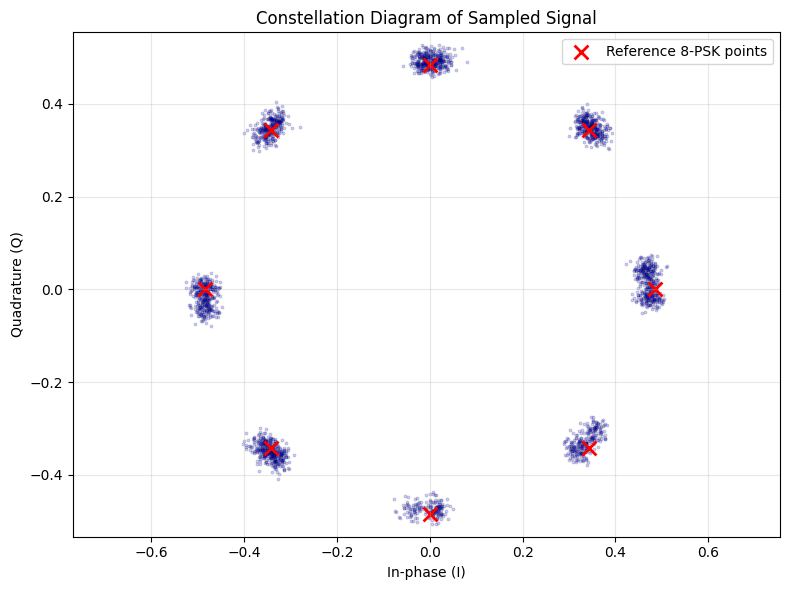

Constellation diagram plotted for 2499 symbols
Mean magnitude: 0.4843
Standard deviation of magnitude: 0.0168

Signal statistics:
Magnitude - Mean: 0.4843, Std: 0.0168
Phase - Mean: -4.26°, Std: 106.01°
SNR estimate: 29.20 dB


In [82]:
# Create constellation diagram for the sampled signal
plt.figure(figsize=(8, 6))

# Plot constellation points
plt.scatter(sampled_signal.real, sampled_signal.imag, alpha=0.2, s=5, c='blue', edgecolors='black', linewidth=0.5)

# Add grid and labels
plt.grid(True, alpha=0.3)
plt.xlabel('In-phase (I)')
plt.ylabel('Quadrature (Q)')
plt.title('Constellation Diagram of Sampled Signal')
plt.axis('equal')

# Add circle markers for reference (assuming 8-PSK constellation)
# Calculate the radius based on the data
radius = np.mean(np.abs(sampled_signal))
angles = np.linspace(0 + config.signal.constellation_offset, 2*np.pi + config.signal.constellation_offset, 8, endpoint=False)
reference_points = radius * np.exp(1j * angles)

plt.scatter(reference_points.real, reference_points.imag, 
           marker='x', s=100, c='red', linewidth=2, label='Reference 8-PSK points')

plt.legend()
plt.tight_layout()
plt.show()

print(f"Constellation diagram plotted for {len(sampled_signal)} symbols")
print(f"Mean magnitude: {np.mean(np.abs(sampled_signal)):.4f}")
print(f"Standard deviation of magnitude: {np.std(np.abs(sampled_signal)):.4f}")

# Calculate and display statistics
magnitudes = np.abs(sampled_signal)
phases = np.angle(sampled_signal, deg=True)

print(f"\nSignal statistics:")
print(f"Magnitude - Mean: {np.mean(magnitudes):.4f}, Std: {np.std(magnitudes):.4f}")
print(f"Phase - Mean: {np.mean(phases):.2f}°, Std: {np.std(phases):.2f}°")
print(f"SNR estimate: {20 * np.log10(np.mean(magnitudes) / np.std(magnitudes)):.2f} dB")

Demodulated 2499 symbols
Symbol range: 0 to 7
First 20 symbols: [5 5 5 5 1 2 4 4 4 4 0 5 0 2 2 2 6 7 5 6]

Symbol distribution:
Symbol 0: 375 occurrences (15.0%)
Symbol 1: 335 occurrences (13.4%)
Symbol 2: 355 occurrences (14.2%)
Symbol 3: 293 occurrences (11.7%)
Symbol 4: 335 occurrences (13.4%)
Symbol 5: 373 occurrences (14.9%)
Symbol 6: 178 occurrences (7.1%)
Symbol 7: 255 occurrences (10.2%)


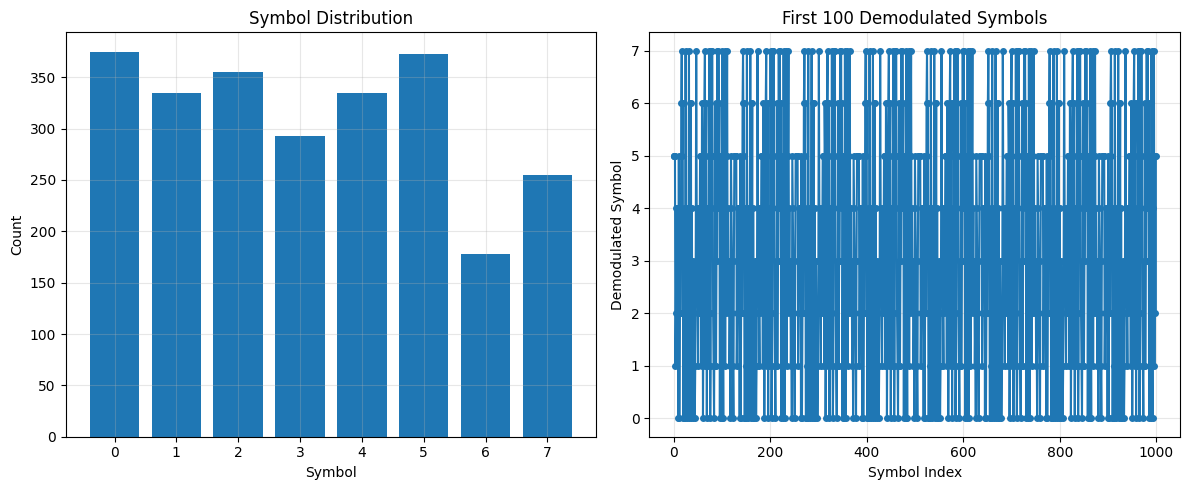


Phase statistics:
Phase range: -180.0° to 180.0°
Phase mean: -4.3°
Phase std: 106.0°


In [83]:
# 8-PSK Demodulation Logic
# Map phase angles to corresponding symbols (0-7)

def demodulate_8psk(complex_signal, phase_offset):
    """
    Demodulate 8-PSK signal by mapping phase angles to symbols
    
    Args:
        complex_signal: Complex-valued signal samples
        phase_offset: Phase offset in radians to align constellation
        
    Returns:
        symbols: Array of demodulated symbols (0-7)
    """
    # Calculate phase angles
    phases = np.angle(complex_signal) + phase_offset
    
    # Normalize phases to [0, 2π)
    phases = phases % (2 * np.pi)
    
    # 8-PSK constellation points (0 to 7)
    # Each symbol spans π/4 radians (45 degrees)
    symbol_spacing = 2 * np.pi / 8  # π/4
    
    # Map phases to symbols
    symbols = np.round(phases / symbol_spacing).astype(int) % 8
    
    return symbols

# Apply demodulation to the sampled signal
demodulated_symbols = demodulate_8psk(sampled_signal, phase_offset=config.signal.constellation_offset)

print(f"Demodulated {len(demodulated_symbols)} symbols")
print(f"Symbol range: {demodulated_symbols.min()} to {demodulated_symbols.max()}")
print(f"First 20 symbols: {demodulated_symbols[:20]}")

# Count symbol occurrences
symbol_counts = np.bincount(demodulated_symbols, minlength=8)
print(f"\nSymbol distribution:")
for i, count in enumerate(symbol_counts):
    print(f"Symbol {i}: {count} occurrences ({count/len(demodulated_symbols)*100:.1f}%)")

# Plot symbol distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(range(8), symbol_counts)
plt.xlabel('Symbol')
plt.ylabel('Count')
plt.title('Symbol Distribution')
plt.grid(True, alpha=0.3)
plt.xticks(range(8))

plt.subplot(1, 2, 2)
plt.plot(range(min(1000, len(demodulated_symbols))), demodulated_symbols[:1000], 'o-', markersize=4)
plt.xlabel('Symbol Index')
plt.ylabel('Demodulated Symbol')
plt.title('First 100 Demodulated Symbols')
plt.grid(True, alpha=0.3)
plt.yticks(range(8))

plt.tight_layout()
plt.show()

# Calculate phase angles for verification
phases_deg = np.angle(sampled_signal, deg=True)
print(f"\nPhase statistics:")
print(f"Phase range: {phases_deg.min():.1f}° to {phases_deg.max():.1f}°")
print(f"Phase mean: {phases_deg.mean():.1f}°")
print(f"Phase std: {phases_deg.std():.1f}°")

## 8PSK & PPM BER


In [84]:
# Calculate number of errors

num_errors_ppm = 0
ppm2_grnd_trth = pd.read_csv('../csv/2ppm_gt.csv')
for i in range(len(ppm2_grnd_trth)):
    if bit_sequence[i] != ppm2_grnd_trth['ppm_bit'][i]:
        num_errors_ppm += 1

print(f"Number of PPM errors: {num_errors_ppm}")
ppm_BER = num_errors_ppm/len(ppm2_grnd_trth)
print(f"PPM Error rate: {ppm_BER:.3f}")


df_8psk_gt = pd.read_csv("../csv/8psk_gt.csv")

df_8psk_gt = df_8psk_gt['8psk_bit'].values
is_wrong = df_8psk_gt != demodulated_symbols
ber_8psk = float(np.sum(is_wrong) / len(is_wrong))
rms_BER = np.sqrt(np.square(ber_8psk) +np.square(ppm_BER))

print(f"Number of psk errors: {np.sum(is_wrong)}")
print(f"8PSK BER: {ber_8psk:.4f}\n")

print(f"Number of ppm errors: {num_errors_ppm}")
print(f"PPM BER: {ppm_BER:.4f}\n")

print(f"RMS BER: {rms_BER:.4f}")

Number of PPM errors: 0
PPM Error rate: 0.000
Number of psk errors: 0
8PSK BER: 0.0000

Number of ppm errors: 0
PPM BER: 0.0000

RMS BER: 0.0000
